### Imports

In [37]:
import os
from os import listdir as ls
from os.path import join as pjoin
import re
import requests
import time

from bs4 import BeautifulSoup as bs
from fake_useragent import UserAgent
import geopandas as gpd
from matplotlib import cm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By
from selenium.webdriver.common.proxy import Proxy, ProxyType

### Webscraping

In [4]:
# Get information from CPRA coastal protection authority.
hydro_monthly = requests.get(
    "https://cims.coastal.louisiana.gov/DataDownload/DataDownload.aspx?type=hydro_monthly"
)

In [5]:
def get_free_proxies():
    """Due to https://stackoverflow.com/questions/59409418/how-to-rotate-selenium-webrowser-ip-address"""
    driver = webdriver.Chrome()
    driver.get('https://sslproxies.org')
    table = driver.find_element(By.TAG_NAME, 'table')
    thead = table.find_element(By.TAG_NAME, 'thead').find_elements(By.TAG_NAME, 'th')
    tbody = table.find_element(By.TAG_NAME, 'tbody').find_elements(By.TAG_NAME, 'tr')
    headers = [th.text.strip() for th in thead]
    proxies = []
    for tr in tbody:
        proxy_data = {}
        tds = tr.find_elements(By.TAG_NAME, 'td')
        for i in range(len(headers)):
            proxy_data[headers[i]] = tds[i].text.strip()
        proxies.append(proxy_data)
    driver.close()
    return [f"{pr['IP Address']}:{pr['Port']}" for pr in proxies]


def setup_driver(ip=None, random_user=False):
    driver_specs = {"options": Options()}
            
    if ip:
        # Rotating proxy
        prox = Proxy()
        prox.proxy_type = ProxyType.MANUAL
        prox.http_proxy = ip
        capabilities = webdriver.DesiredCapabilities.CHROME
        prox.add_to_capabilities(capabilities)
        driver_specs["desired_capabilities"] = capabilities
    if random_user:
        # Rotating user-agent
        driver_specs["options"].add_argument(
            f"user-agent={UserAgent().random}")
    return webdriver.Chrome(**driver_specs)
    
           
def chrome_bot(rotate_ip=False):
    email = "rpark1@tulane.edu"
    # Get the name of each project for field extract
    projects = re.findall("[A-Z]{2}-[0-9]{4}[\ -].*\)", hydro_monthly.text) # \([0-9]{2}/.*\)
    # Optional Start condition
    projects = projects[projects.index("BA-0170 - BREACH MANAGEMENT PLAN (05/15/2007 to 08/24/2021 [2,419])"):]
    for p in projects:
        # Start chrome bot.
        driver = setup_driver()
        # Go to CPRA.
        driver.get("https://cims.coastal.louisiana.gov/DataDownload/DataDownload.aspx?type=hydro_monthly")
        # Check off for long/lat data
        driver.find_element_by_id("MainContent_CB_StationLatLong").click()
        # Select project.
        driver.find_element_by_id("MainContent_DDL_ProjectList").send_keys(p)
        # Press download
        driver.find_element_by_id("MainContent_BTN_DownLoad").click()
        try:
            # File small enough to auto extract.
            # Name the extract file
            driver.find_element_by_id("MainContent_TB_Filename").send_keys(p.split()[0])
            # Submit extraction 
            driver.find_element_by_id("MainContent_BTN_OkFilename").click()
        except:
            # Otherwise must go through email.
            driver.find_element_by_id("MainContent_TB_OkCancelEmailInfo").send_keys(email)
            # Submit
            driver.find_element_by_id("MainContent_BTN_OkCancelEmailOk").click()
        # Close for next request.
        time.sleep(1.1)
        driver.close()

# Download each project found on the website locally, named into zip files after each project
# Note: some of these zip files are too big and get emailed to the email specified in chrome_bot
# chrome_bot()
# Was it worth it ??? no # update: yes...?

### Assembly and Tidying

In [21]:
# After unzipping and renaming emailed files, we are left with csv files.
def combine_from_zip():
    # Concatonate csv files and create project column.
    # My data location currently # TODO: decide on dir structure on github.
    hydro_m_path = pjoin("data", "CPRA_Hydro_Monthly")
    # data from storage
    for f in ls(hydro_m_path):
        print(f)
        # Skip non csv.
        if ".csv" not in f:
            continue
        fpath = pjoin(hydro_m_path, f)
        subdf = pd.read_csv(fpath, encoding="latin1")
        hydmon = hydmon.append(subdf)
combine_from_zip()
hydmon.head()

AT-0002.csv
TE-0146.csv
CS-0028-1.csv
PO-0075.csv
CS-0018.csv
CS-0024.csv
CS-0030.csv
MR-0013.csv
TE-0033.csv
MR-0012.csv
MR-0006.csv
CS-0031.csv
CS-0025.csv
CS-0019.csv
BA-0024.csv
LA-0013.csv
AT-0015.csv
LA-0039.csv
CS-0028-2.csv
BA-0026.csv
CS-0027.csv
MR-0011.csv
BA-0153.csv
CS-0032.csv
BA-0027.csv
BA-0033.csv
CS-0028-3.csv
TE-0007-D.csv
LA-0206.csv
AT-0004.csv
BA-0037.csv
PO-0067.csv
BA-0023.csv
BS-0003-A.csv
.DS_Store
TE-0034.csv
PO-0009-A.csv
CS-0023.csv
PO-0066.csv
BA-0022.csv
TE-0007-A.csv
BA-0020.csv
BS-0003-B.csv
CS-0021.csv
CS-0009.csv
PO-0104.csv
TE-0023.csv
MR-0016.csv
TE-0022.csv
CS-0008.csv
TV-0054.csv
CS-0020.csv
BA-0021.csv
BA-0017-A.csv
TE-0007-B.csv
BS-0024.csv
BS-0030.csv
BS-0018.csv
TV-0011-B1.csv
PO-0016.csv
ME-0024.csv
TE-0051.csv
ME-0030.csv
ME-0031.csv
TE-0044.csv
ME-0019.csv
TV-0002-B.csv
PO-0017.csv
BA-0047.csv
PO-0003.csv
BS-0019.csv
BS-0025.csv
BS-0033.csv
PO-0029.csv
BS-0004-A.csv
PO-0001.csv
TV-0018.csv
TV-0002-A.csv
TV-0019.csv
PO-0014.csv
PO-0028.csv
B

/Users/ryan/miniconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3296: DtypeWarning: Columns (1,19,20,21,22,23,24,26,28,29,31,34) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


CS-0002.csv
CS-0016.csv
BA-0003.csv
TE-0032-A.csv
MR-0169.csv
t.py
PO-0003-A.csv
BA-0217.csv
BA-0004-C.csv
BA-0001.csv
BA-0015.csv
CS-0014.csv
TV-0074.csv
BA-0175.csv
TE-0002.csv
TE-0003.csv
BA-0174.csv
CS-0029.csv
CS-0001.csv
BA-0014.csv


,CPRA Station ID,Original Collector Station ID,Date (mm/dd/yyyy),Time (hh:mm),Time Zone,Staff Gauge (ft),Geoid,Station Depth (ft),Measurement Depth (ft),Water Temperature (°C),...,Silica (unfiltered; mg/L),Silica (filtered; mg/L),Total Suspended Solids (mg/L),Volatile Suspended Solids (mg/L),Secchi (ft),Fecal Coliform (MPN/100ml),Organization Name,Comments,Latitude,Longitude
0,CRMS6304-P01,NaN,10/19/2009,10:40,CST,0.67,NaN,NaN,0.328,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,COASTAL ESTUARY SERVICES LLC,NaN,29.420313,-91.279049
1,CRMS6304-P01,NaN,11/12/2009,13:51,CST,2.28,NaN,NaN,0.328,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,COASTAL ESTUARY SERVICES LLC,NaN,29.420313,-91.279049
2,CRMS6304-P01,NaN,11/12/2009,13:51,CST,2.28,NaN,NaN,0.984,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,COASTAL ESTUARY SERVICES LLC,NaN,29.420313,-91.279049
3,CRMS6304-P01,NaN,12/28/2009,12:31,CST,1.28,NaN,NaN,0.328,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,COASTAL ESTUARY SERVICES LLC,NaN,29.420313,-91.279049
4,CRMS6304-P01,NaN,12/28/2009,12:31,CST,1.28,NaN,NaN,0.984,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,COASTAL ESTUARY SERVICES LLC,NaN,29.420313,-91.279049
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
879,CRMS0261-V51,NaN,8/7/2018,11:23,CST,NaN,NaN,NaN,0.984,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,COASTAL ESTUARY SERVICES LLC,depth of water on marsh = 0.2 ft,29.601989,-90.104419
880,CRMS0261-V51,NaN,8/20/2019,13:06,CST,0.56,GEOID12A,NaN,0.328,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,COASTAL ESTUARY SERVICES LLC,NaN,29.601989,-90.104419
881,CRMS0261-V51,NaN,8/20/2019,13:06,CST,0.56,GEOID12A,NaN,0.984,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,COASTAL ESTUARY SERVICES LLC,Dry,29.601989,-90.104419
882,CRMS0261-V51,NaN,8/19/2021,13:25,CST,1.58,GEOID12A,NaN,0.328,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,COASTAL ESTUARY SERVICES LLC,Water Level: 0.5 ft Above Marsh;,29.601989,-90.104419


In [67]:
# Focus on only the columns we care about
cols = ["CPRA Station ID", "Date (mm/dd/yyyy)", "Time (hh:mm)", "Measurement Depth (ft)",
        "Staff Gauge (ft)", "Water Temperature (°C)", "Specific Conductance (uS/cm)",
        "Salinity (ppt)", "pH (pH units)", "Latitude", "Longitude"]
# print(hydmon["Time Zone"].unique()) # all CST
# hydmon = hydmon[cols]
if "Time (hh:mm)" in hydmon.columns:
    # Create datetime columns
    hydmon.loc[:, "Datetime"] = pd.to_datetime(
    hydmon["Date (mm/dd/yyyy)"] + "_" + hydmon["Time (hh:mm)"],
    format="%m/%d/%Y_%H:%M")
    hydmon = hydmon.drop(["Time (hh:mm)", "Date (mm/dd/yyyy)"], axis=1)
hydmon

,CPRA Station ID,Measurement Depth (ft),Staff Gauge (ft),Water Temperature (°C),Specific Conductance (uS/cm),Salinity (ppt),pH (pH units),Latitude,Longitude,Datetime
0,CRMS6304-P01,0.328,0.67,NaN,NaN,NaN,NaN,29.420313,-91.279049,2009-10-19 10:40:00
1,CRMS6304-P01,0.328,2.28,NaN,NaN,NaN,NaN,29.420313,-91.279049,2009-11-12 13:51:00
2,CRMS6304-P01,0.984,2.28,NaN,NaN,NaN,NaN,29.420313,-91.279049,2009-11-12 13:51:00
3,CRMS6304-P01,0.328,1.28,NaN,NaN,NaN,NaN,29.420313,-91.279049,2009-12-28 12:31:00
4,CRMS6304-P01,0.984,1.28,NaN,NaN,NaN,NaN,29.420313,-91.279049,2009-12-28 12:31:00
...,...,...,...,...,...,...,...,...,...,...
879,CRMS0261-V51,0.984,NaN,NaN,NaN,NaN,NaN,29.601989,-90.104419,2018-08-07 11:23:00
880,CRMS0261-V51,0.328,0.56,NaN,NaN,NaN,NaN,29.601989,-90.104419,2019-08-20 13:06:00
881,CRMS0261-V51,0.984,0.56,NaN,NaN,NaN,NaN,29.601989,-90.104419,2019-08-20 13:06:00
882,CRMS0261-V51,0.328,1.58,NaN,NaN,NaN,NaN,29.601989,-90.104419,2021-08-19 13:25:00


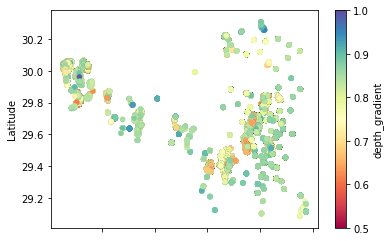

In [44]:
# Create a quick plot to look at where these sites are located.
def map_range(df, x):
    normlin = (df[x] - df[x].min()) / (df[x].max() - df[x].min())
    shift = normlin*0.5 + 0.5
    return shift

hydmon.loc[:, "depth_gradient"] = map_range(hydmon, "Water Temperature (°C)")

hydmon.plot.scatter(x="Longitude", y="Latitude", c="depth_gradient", cmap=cm.get_cmap("Spectral"));
plt.show()

In [ ]:
# SNIPS
#         if i == 2:
#             # Give email for offline extraction.
#             email_text = driver.find_element_by_id("MainContent_TB_OkCancelEmailInfo")
#             email_text.send_keys(email)
#             driver.find_element_by_id("MainContent_BTN_OkCancelEmailOk").click()
#             print(driver.page_source)


# <button type="button" class="ui-button ui-widget ui-state-default ui-corner-all ui-button-text-only" role="button"><span class="ui-button-text">Submit</span></button>
# <button type="button" class="ui-button ui-widget ui-state-default ui-corner-all ui-button-text-only" role="button"><span class="ui-button-text">Submit</span></button>
# <input name="ctl00$MainContent$TB_OkCancelEmailInfo" type="text" id="MainContent_TB_OkCancelEmailInfo" tabindex="1" style="width:300px;">
# <input type="submit" name="ctl00$MainContent$BTN_OkCancelEmailOk" value="Ok" onclick="hideOkCancelEmailModalWindow();WebForm_DoPostBackWithOptions(new WebForm_PostBackOptions(&quot;ctl00$MainContent$BTN_OkCancelEmailOk&quot;, &quot;&quot;, true, &quot;&quot;, &quot;&quot;, false, false))" id="MainContent_BTN_OkCancelEmailOk" tabindex="10">